<a href="https://colab.research.google.com/github/ESJoGithub/PythonStudy/blob/main/Keras_220921_MNIST_%EC%8B%A4%EC%8A%B502.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!ln -s /content/drive/MyDrive /mydrive

ln: failed to create symbolic link '/mydrive/MyDrive': Input/output error


In [38]:
%cd /mydrive

/content/drive/MyDrive


In [39]:
!mkdir mnist

mkdir: cannot create directory ‘mnist’: File exists


## __NN Layer 구조 변경 & 드롭아웃 일괄적용__
---
epoch수를 늘리고 callback함수를 넣되 patience 횟수를 키운다.

SGD, adam, rmsprop 각 optimizer별 batch_size를 변경해볼 것

### **1. Library Import**

In [40]:
from keras import datasets, layers, models                
from tensorflow import keras                         # to_categorical 함수
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
(train_imgs, train_labels), (test_imgs, test_labels) = datasets.mnist.load_data()

### **2. 데이터 확인 및 전처리**

In [42]:
train_imgs = train_imgs/255.0
test_imgs = test_imgs/255.0

In [43]:
print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


In [44]:
train_imgs = train_imgs.reshape((60000, 28, 28, 1))
test_imgs = test_imgs.reshape((10000, 28, 28, 1))

In [45]:
train_labels = keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = keras.utils.to_categorical(test_labels, num_classes=10)

### __모델 변경__

---
CNN 특성 및 MNIST 자료 특성을 고려할 때, 초기의 세부적인 데이터 정보보다 여러 필터를 거치고난 후의 구조적인 특징정보가 판단에 더 중요할 것이라고 가정하고 출력층에 가까울수록 필터 수를 점점 키워나가는 방식으로 수정

Dropout 추가 (64-0.2, 128-0.5)
epoch=100 EarlyStop patient = 10으로 키워서 진행해본다. 

#### __1. batch_size=128, 출력 직전층 activation='sigmoid', optimizer='SGD'__ 

In [46]:
import keras

In [47]:
model_1 = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation = 'sigmoid'),
  layers.Dense(10, activation = 'softmax')
])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 dropout_10 (Dropout)        (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [48]:
model_1.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('mnist/model_1.h1', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
hist_1 = model_1.fit(train_imgs, train_labels, epochs=100, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Epoch 1/100
372/375 [============================>.] - ETA: 0s - loss: 2.2898 - accuracy: 0.1577
Epoch 1: val_accuracy improved from -inf to 0.20225, saving model to mnist/model_1.h1
375/375 [==============================] - 5s 13ms/step - loss: 2.2894 - accuracy: 0.1587 - val_loss: 2.2506 - val_accuracy: 0.2023
Epoch 2/100
370/375 [============================>.] - ETA: 0s - loss: 2.0079 - accuracy: 0.4366
Epoch 2: val_accuracy improved from 0.20225 to 0.67358, saving model to mnist/model_1.h1
375/375 [==============================] - 5s 14ms/step - loss: 2.0028 - accuracy: 0.4382 - val_loss: 1.5649 - val_accuracy: 0.6736
Epoch 3/100
368/375 [============================>.] - ETA: 0s - loss: 1.2453 - accuracy: 0.6693
Epoch 3: val_accuracy improved from 0.67358 to 0.80558, saving model to mnist/model_1.h1
375/375 [==============================] - 5s 14ms/step - loss: 1.2407 - accuracy: 0.6709 - val_loss: 0.8703 - val_accuracy: 0.8056
Epoch 4/100
370/375 [============================

In [50]:
result = model_1.evaluate(test_imgs, test_labels)
print("\n테스트 정확도: %.4f" %(result)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0388 - accuracy: 0.9886

테스트 정확도: 0.9886


In [51]:
loaded_model = load_model('mnist/model_1.h1')
result_loaded = loaded_model.evaluate(test_imgs, test_labels)
print("\n불러온 모델 테스트 정확도: %.4f" %(result_loaded)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0387 - accuracy: 0.9888

불러온 모델 테스트 정확도: 0.9888


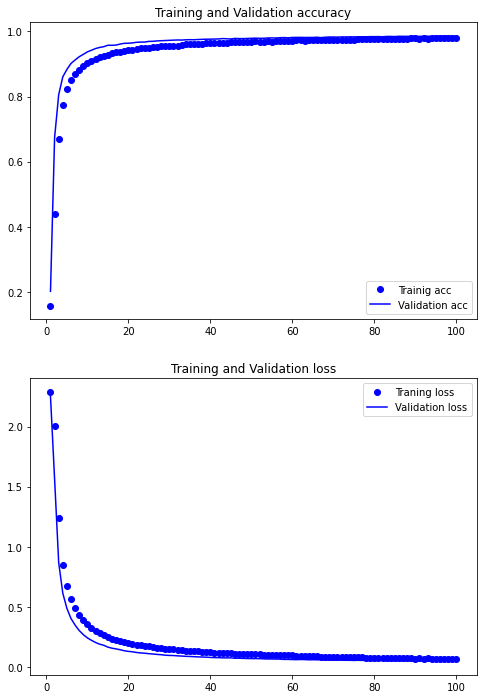

In [52]:
acc = hist_1.history['accuracy']
val_acc = hist_1.history['val_accuracy']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(8, 12))
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 1, 2)
ax1.plot(epochs, acc, 'bo', label='Trainig acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title("Training and Validation accuracy")
ax1.legend()
ax2.plot(epochs, loss, 'bo', label='Traning loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title("Training and Validation loss")
ax2.legend()
plt.show()

In [53]:
df = pd.DataFrame([['CNN', 'model_1', '32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Flatten-64(sigmoid)-10(softmax)]', 'SGD', 100, 128, 0.2, 'es/mc', 
                    "%.4f"%(result)[1], "%.4f"%(result_loaded)[1], "%.4f"%(result)[0], "%.4f"%(result_loaded)[0]]],
                  columns=['모델', 'Name', 'Structure', 'Optimizer', 'epochs', 'batch_size', 'validation_split', 'callback', 'Accuracy', 'MC_Accuracy', 'Loss', 'MC_Loss'])

#### __2. batch_size=128, 출력 직전층 activation='sigmoid', optimizer='rmsprop'__ 

In [54]:
model_1_1 = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation = 'sigmoid'),
  layers.Dense(10, activation = 'softmax')
])
model_1_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 dropout_13 (Dropout)        (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [55]:
model_1_1.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('mnist/model_1_1.h1', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
hist_1_1 = model_1_1.fit(train_imgs, train_labels, epochs=100, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Epoch 1/100
374/375 [============================>.] - ETA: 0s - loss: 0.4102 - accuracy: 0.8901
Epoch 1: val_accuracy improved from -inf to 0.97300, saving model to mnist/model_1_1.h1
375/375 [==============================] - 4s 10ms/step - loss: 0.4094 - accuracy: 0.8904 - val_loss: 0.1018 - val_accuracy: 0.9730
Epoch 2/100
374/375 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9703
Epoch 2: val_accuracy improved from 0.97300 to 0.98300, saving model to mnist/model_1_1.h1
375/375 [==============================] - 3s 9ms/step - loss: 0.1043 - accuracy: 0.9703 - val_loss: 0.0587 - val_accuracy: 0.9830
Epoch 3/100
368/375 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.98300 to 0.98533, saving model to mnist/model_1_1.h1
375/375 [==============================] - 3s 9ms/step - loss: 0.0729 - accuracy: 0.9774 - val_loss: 0.0473 - val_accuracy: 0.9853
Epoch 4/100
372/375 [========================

In [57]:
result = model_1_1.evaluate(test_imgs, test_labels)
print("\n테스트 정확도: %.4f" %(result)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.9934

테스트 정확도: 0.9934


In [58]:
loaded_model = load_model('mnist/model_1_1.h1')
result_loaded = loaded_model.evaluate(test_imgs, test_labels)
print("\n불러온 모델 테스트 정확도: %.4f" %(result_loaded)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0211 - accuracy: 0.9943

불러온 모델 테스트 정확도: 0.9943


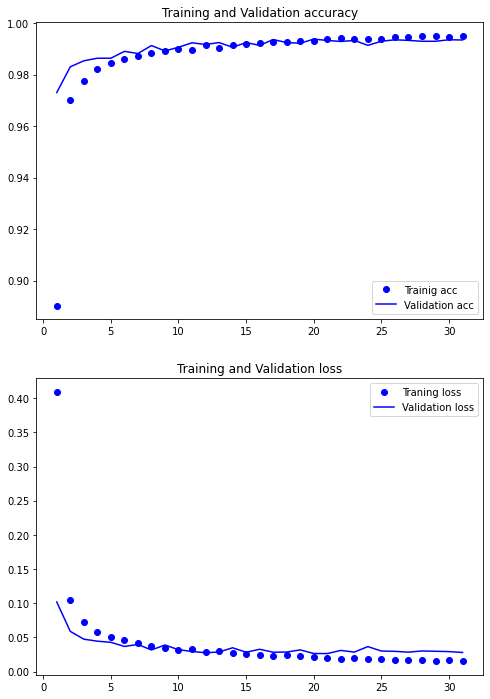

In [59]:
acc = hist_1_1.history['accuracy']
val_acc = hist_1_1.history['val_accuracy']
loss = hist_1_1.history['loss']
val_loss = hist_1_1.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(8, 12))
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 1, 2)
ax1.plot(epochs, acc, 'bo', label='Trainig acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title("Training and Validation accuracy")
ax1.legend()
ax2.plot(epochs, loss, 'bo', label='Traning loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title("Training and Validation loss")
ax2.legend()
plt.show()

In [60]:
df.loc[1]=['CNN', 'model_1_1', '32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Flatten-64(sigmoid)-10(softmax)]', 'rmsprop', 100, 128, 0.2, 'es/mc', "%.4f"%(result)[1], "%.4f"%(result_loaded)[1], "%.4f"%(result)[0], "%.4f"%(result_loaded)[0]]

#### __3.  batch_size=128, 출력 직전층 activation='sigmoid', optimizer='adam'__ 

In [61]:
model_1_2 = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation = 'sigmoid'),
  layers.Dense(10, activation = 'softmax')
])
model_1_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                 

In [62]:
model_1_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('mnist/model_1_2.h1', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
hist_1_2 = model_1_2.fit(train_imgs, train_labels, epochs=100, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.8803
Epoch 1: val_accuracy improved from -inf to 0.97492, saving model to mnist/model_1_2.h1
375/375 [==============================] - 4s 10ms/step - loss: 0.4526 - accuracy: 0.8803 - val_loss: 0.1034 - val_accuracy: 0.9749
Epoch 2/100
370/375 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9689
Epoch 2: val_accuracy improved from 0.97492 to 0.98175, saving model to mnist/model_1_2.h1
375/375 [==============================] - 3s 9ms/step - loss: 0.1130 - accuracy: 0.9690 - val_loss: 0.0687 - val_accuracy: 0.9818
Epoch 3/100
374/375 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.98175 to 0.98592, saving model to mnist/model_1_2.h1
375/375 [==============================] - 3s 9ms/step - loss: 0.0786 - accuracy: 0.9776 - val_loss: 0.0482 - val_accuracy: 0.9859
Epoch 4/100
368/375 [========================

In [64]:
result = model_1_2.evaluate(test_imgs, test_labels)
print("\n테스트 정확도: %.4f" %(result)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0231 - accuracy: 0.9938

테스트 정확도: 0.9938


In [65]:
loaded_model = load_model('mnist/model_1_2.h1')
result_loaded = loaded_model.evaluate(test_imgs, test_labels)
print("\n불러온 모델 테스트 정확도: %.4f" %(result_loaded)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0219 - accuracy: 0.9942

불러온 모델 테스트 정확도: 0.9942


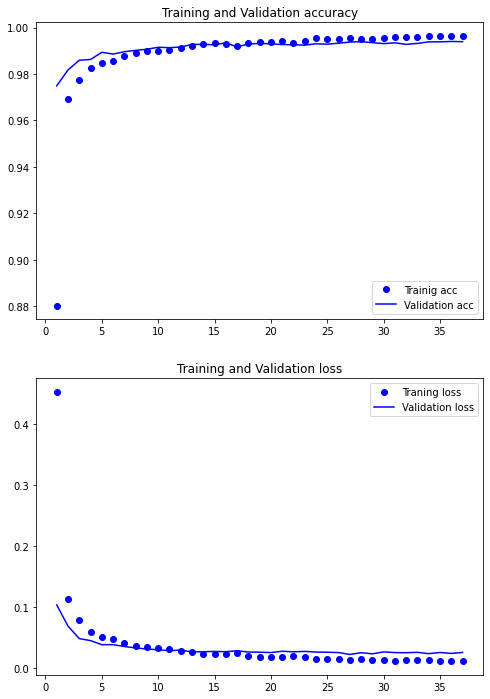

In [66]:
acc = hist_1_2.history['accuracy']
val_acc = hist_1_2.history['val_accuracy']
loss = hist_1_2.history['loss']
val_loss = hist_1_2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(8, 12))
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 1, 2)
ax1.plot(epochs, acc, 'bo', label='Trainig acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title("Training and Validation accuracy")
ax1.legend()
ax2.plot(epochs, loss, 'bo', label='Traning loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title("Training and Validation loss")
ax2.legend()
plt.show()

In [67]:
df.loc[2]=['CNN', 'model_1_2', '32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Flatten-64(sigmoid)-10(softmax)]', 'adam', 100, 128, 0.2, 'es/mc', "%.4f"%(result)[1], "%.4f"%(result_loaded)[1], "%.4f"%(result)[0], "%.4f"%(result_loaded)[0]]

In [68]:
df.head()

,모델,Name,Structure,Optimizer,epochs,batch_size,validation_split,callback,Accuracy,MC_Accuracy,Loss,MC_Loss
0,CNN,model_1,32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Fl...,SGD,100,128,0.2,es/mc,0.9886,0.9888,0.0388,0.0387
1,CNN,model_1_1,32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Fl...,rmsprop,100,128,0.2,es/mc,0.9934,0.9943,0.0259,0.0211
2,CNN,model_1_2,32(relu)-64(drop0.2/relu)-128(drop0.5/relu)-Fl...,adam,100,128,0.2,es/mc,0.9938,0.9942,0.0231,0.0219


In [69]:
df.to_csv("./mnist/220921_실습_2.csv", header=True, sep=',', na_rep='NaN', float_format = '%.4f', encoding='utf-8', line_terminator='\n')